# Example Burgers' equation

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the Burgers' equation. 

We start by importing the required libraries and setting the plotting style:

In [1]:
import numpy as np
import torch
from scipy.io import loadmat
from deepymod_torch.library_function import *
from deepymod_torch.DeepMod import DeepMoD

import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

np.random.seed(40)

%load_ext autoreload
%autoreload 2

Next, we prepare the dataset.

In [2]:
data = loadmat('../data/processed/Advection_diffusion.mat')
usol = np.real(data['Expression1'])
usol= usol.reshape((51,51,61,4))

x_v= usol[:,:,:,0]
y_v = usol[:,:,:,1]
t_v = usol[:,:,:,2]
u_v = usol[:,:,:,3]

Let's plot it to get an idea of the data:

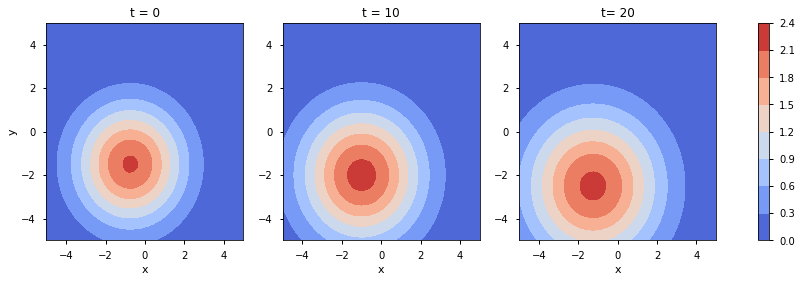

In [3]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im0 = axes[0].contourf(x_v[:,:,0], y_v[:,:,0], u_v[:,:,0], cmap='coolwarm')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('t = 0')

im1 = axes[1].contourf(x_v[:,:,10], y_v[:,:,10], u_v[:,:,10], cmap='coolwarm')
axes[1].set_xlabel('x')
axes[1].set_title('t = 10')

im2 = axes[2].contourf(x_v[:,:,20], y_v[:,:,20], u_v[:,:,20], cmap='coolwarm')
axes[2].set_xlabel('x')
axes[2].set_title('t= 20')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()

In [4]:
X = np.transpose((t_v.flatten(),x_v.flatten(), y_v.flatten()))
y = u_v.reshape((u_v.size, 1))

print(X.shape, y.shape)

(158661, 3) (158661, 1)


As we can see, $X$ has 2 dimensions, $\{x, t\}$, while $y$ has only one, $\{u\}$. Always explicity set the shape (i.e. $N\times 1$, not $N$) or you'll get errors. This dataset is noiseless, so let's add $5\%$ noise:

In [5]:
noise_level = 0.05
y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size, 1)

The dataset is also much larger than needed, so let's hussle it and pick out a 1000 samples:

In [6]:
number_of_samples = 1000

idx = np.random.permutation(y.size)
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_noisy[idx, :][:number_of_samples], dtype=torch.float32)

In [7]:
print(X_train.shape, y_train.shape)

torch.Size([1000, 3]) torch.Size([1000, 1])


## Configure the neural network

We now setup the options for DeepMoD. There's as few dictionaries to fill, starting with the 'optim config', which sets the maximal number of iterations and the amplitude of the $L_1$ penalty

In [8]:
optim_config = {'lambda': 10**-5, 'max_iterations': 10000}

Next we choose the size of the neural network 

In [9]:
network_config = {'input_dim': 3, 'hidden_dim': 20, 'layers': 5, 'output_dim': 1}

DeepMoD accepts any arbitrary library function and any options for it can be given through *the library_config*. The library function for the burgers case accepts a maximum order for the polynomial and derivative terms.

In [10]:
lib_config = {'type': library_2Din_1Dout, 'poly_order': 1, 'diff_order': 3}

## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data. We also need to specify which library function we wish to use. You can build any library you want and just pass is through this command:

In [ ]:
sparse_coeff_vector, sparsity_mask, network = DeepMoD(X_train, y_train, network_config, lib_config, optim_config)

Epoch | Total loss | MSE | PI | L1 
0 1.3E+00 5.2E-01 8.0E-01 2.4E-03
tensor([[ 0.8375],
        [-0.2271],
        [-0.4795],
        [ 0.6621],
        [ 0.9936],
        [ 0.2389],
        [-0.7743],
        [ 0.1239],
        [-0.8033],
        [ 0.4016],
        [-0.1669],
        [-0.7719]], requires_grad=True)
500 3.5E-02 1.7E-02 1.8E-02 9.7E-05
tensor([[ 0.3873],
        [ 0.2517],
        [ 0.3697],
        [ 0.5945],
        [ 0.2031],
        [-0.1151],
        [-0.8219],
        [ 0.0981],
        [-0.2315],
        [-0.3856],
        [-1.3356],
        [-0.7728]], requires_grad=True)
1000 8.4E-03 4.6E-03 3.7E-03 9.4E-05
tensor([[ 0.1532],
        [ 0.3252],
        [ 0.3781],
        [ 0.7668],
        [ 0.0265],
        [-0.1292],
        [-0.5654],
        [-0.0777],
        [-0.5601],
        [-0.2134],
        [-1.4910],
        [-0.6316]], requires_grad=True)
1500 3.9E-03 2.6E-03 1.3E-03 7.4E-05
tensor([[ 0.0760],
        [ 0.3181],
        [ 0.3069],
        [ 0.6281

Now that DeepMoD has converged, it has found the following equation:

In [34]:
print('Final result:')
print(sparse_coeff_vector, sparsity_mask)

Final result:
(tensor([[ 0.0994],
        [-1.0001]], requires_grad=True),) (tensor([2, 5]),)
